In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# Class to interface with report .xvg / log data

In [2]:
class PymemdynReport:
    def __init__(self, report_directory: str):
        """
        Initializes the ReportAnalyzer with the path to the report's directory.
        :param report_directory: Path to the report subdirectory (e.g., './reports/4EIY')
        """
        self.report_directory = report_directory
        self.pdbcode = self.report_directory[-4:]
        self.xvg_files = self._get_xvg_files()  # List of .xvg files in the directory

        # split .xvg files in rmsX (e.g. 'rmsd-backbone...') & 'system' files (e.g. 'pressure')
        self.rmsx_xvg_files = [x for x in self.xvg_files if x.startswith('rms')] 
        self.sys_xvg_files = set(self.xvg_files) - set(self.rmsx_xvg_files)

    def _get_xvg_files(self):
        """
        Returns a list of all .xvg files in the report directory.
        """
        xvgs = [f for f in os.listdir(self.report_directory) if f.endswith('.xvg')]
        rmsX_items = sorted([item for item in xvgs if item.startswith('rms')])
        non_rmsX_items = sorted([item for item in xvgs if not item.startswith('rms')])
        sorted_xvgs = rmsX_items + non_rmsX_items
        return sorted_xvgs

    def load_data(self, filename: str):
        """
        Loads the .xvg file into numpy arrays, skipping comment lines starting with '#' or '@'.
        :param filename: Name of the .xvg file to load
        :return: Two numpy arrays (x, y)
        """
        file_path = os.path.join(self.report_directory, filename)
        x, y = np.loadtxt(file_path, comments=["#", "@"], unpack=True)
        return x, y

    def plot(self, selection=None):
        """
        Creates a subplot for each .xvg data file and displays them in a single figure.
        :param selection: .xvg data to plot: 'system', 'residualmeans', or None to plot all .xvg's.
        """
        if selection == 'system':
            data_to_plot = self.sys_xvg_files
        elif selection == 'residualmeans':
            data_to_plot = self.rmsx_xvg_files
        elif selection is None:
            data_to_plot = self.xvg_files
        else:
            return ValueError(f'{selection} is not a valid data selection (\'system\', \'residualmeans\', or None to plot all)')

        self._xy_plotlabels = {
            'rmsd-all-atom-vs-start.xvg': ['Time (ps)', 'RMSD (nm)'],
            'rmsd-backbone-vs-start.xvg': ['Time (ps)', 'RMSD (nm)'],
            'rmsd-calpha-vs-start.xvg': ['Time (ps)', 'RMSD (nm)'],
            'rmsf-per-residue.xvg': ['Residue number', 'RMS fluctuation (nm)'],
            'pressure.xvg': ['Time (ps)', 'Pressure (bar)'],
            'volume.xvg': ['Time (ps)', 'Volume (nm^3)'],
            'temp.xvg': ['Time (ps)', 'Temperature (K)'],
            'tot_ener.xvg': ['Time (ps)', 'Total Energy (kJ/mol)']
        }

        # Determine the number of rows and columns for the subplots (e.g., 4x4 grid)
        nplots = len(data_to_plot)
        ncols = 4  # Fixed number of columns (4 for 4x4 grid)
        nrows = (nplots + ncols - 1) // ncols  # Calculate the number of rows needed

        # set figure size based on data selection (double / single row)
        if data_to_plot == self.xvg_files:
            fs = (15, 10)
        else:
            fs = (15, 5)

        # Create a figure with subplots
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=fs)
        axes = axes.flatten()  # Flatten axes array to easily iterate over subplots
        fig.suptitle(f"{self.report_directory[-4:]}", x=0.5, fontsize=16, fontweight='bold')

        # Loop through each .xvg file and plot on its own subplot
        for i, xvg_file in enumerate(data_to_plot):
            x, y = self.load_data(xvg_file)
            ax = axes[i]  # Select the subplot
            ax.plot(x, y)
            if selection == 'residualmeans':
                if xvg_file != 'rmsf-per-residue.xvg':
                    ax.axvline(x=0, color='r', linestyle='--', alpha=0.3, label='Heavy atoms relax. 1000 kJ/mol/nm^2')
                    ax.axvline(x=500, color='r', linestyle='--', alpha=0.3, label='Heavy atoms relax. 800 kJ/mol/nm^2')
                    ax.axvline(x=1000, color='r', linestyle='--', alpha=0.3, label='Heavy atoms relax. 600 kJ/mol/nm^2')
                    ax.axvline(x=1500, color='r', linestyle='--', alpha=0.3, label='Heavy atoms relax. 400 kJ/mol/nm^2')
                    ax.axvline(x=2000, color='r', linestyle='--', alpha=0.3, label='Heavy atoms relax. 200 kJ/mol/nm^2')
                    ax.axvline(x=2500, color='g', linestyle='--', alpha=0.3, label='BW relaxation')

                # if xvg_file == 'rmsd-all-atom-vs-start':
                #     lines_labels = ax.get_legend_handles_labels()
                #     lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
                #     fig.legend(lines, labels)

            ax.set_title(xvg_file.replace('.xvg', ''))
            
            # set labels based on dict
            ax.set_xlabel(f'{self._xy_plotlabels.get(xvg_file)[0]}')
            ax.set_ylabel(f'{self._xy_plotlabels.get(xvg_file)[1]}')


        # Remove any empty subplots (if the number of files doesn't fill the grid)
        for i in range(nplots, len(axes)):
            fig.delaxes(axes[i])


        plt.tight_layout()
            
        plt.show()


In [3]:
Report_2RH1 = PymemdynReport('./reports/2RH1')
Report_5OLZ = PymemdynReport('./reports/5OLZ')
Report_4S0V = PymemdynReport('./reports/4S0V')
Report_4EIY = PymemdynReport('./reports/4EIY')
Report_4XNV = PymemdynReport('./reports/4XNV')
Report_5OLO = PymemdynReport('./reports/5OLO')

PMD_Reports = [Report_2RH1,
               Report_5OLZ,
               Report_4S0V,
               Report_4EIY,
               Report_4XNV,
               Report_5OLO]

# PyMemDyn membrane insertion results of 6 systems.

The 6 GPCR structures (+ co-crystallized ligands) that were inserted using PyMemDyn were:
1. 5OLZ (adenosine A2Ar)
2. 4S0V (OX2)
3. 4XNV (P2Y1)
4. 2RH1 (beta 2 adrenergic receptor)
5. 4EIY (adenosine A2Ar)
6. 5OLO (adenosine A2Ar)

A description of how each protein structure `.pdb` file was acquired and processed for membrane insertion is provided in `pdb_file_processing.md`.

## Sanity check: trajectories of system parameters

The PyMemDyn protocol involves several relaxation / equilibration steps: 

| Stage | Restrained Atoms | Force constant (kJ mol^-1 Ä^-1 nm^2) | Time (ns) |
|---|---|---|---|
| Minimization |  |  | (Max 500 steps) |
| 1 | Protein Heavy Atoms | 1000 | 0.5 |
| 2 | Protein Heavy Atoms | 800 | 0.5 |
| 3 | Protein Heavy Atoms | 600 | 0.5 |
| 4 | Protein Heavy Atoms | 200 | 0.5 |
| 5 | Protein Heavy Atoms | 200 | 0.5 |
| BW relaxation | Venkatakrishnan pairs | 200 | 2.5 |

In the following figure, the volume (nm^3), temperature (K), pressure (bar), and total energy (kJ/mol) of the protein-membrane systems are plotted. It can be observed that these parameters converge to sensible values after equilibration, e.g. volume and pressure quickly stabilize, and temperature remains around 310 K (37 Celsius). The total energy of the also slowly decreases as the protein-membrane systems gets equilibrated and experiences less forceful atom restraints over time, and converges to a minimal range. Naturally, these system parameters will not converge to a *single, exact value*, due too the dynamic nature of the protein-membrane system.


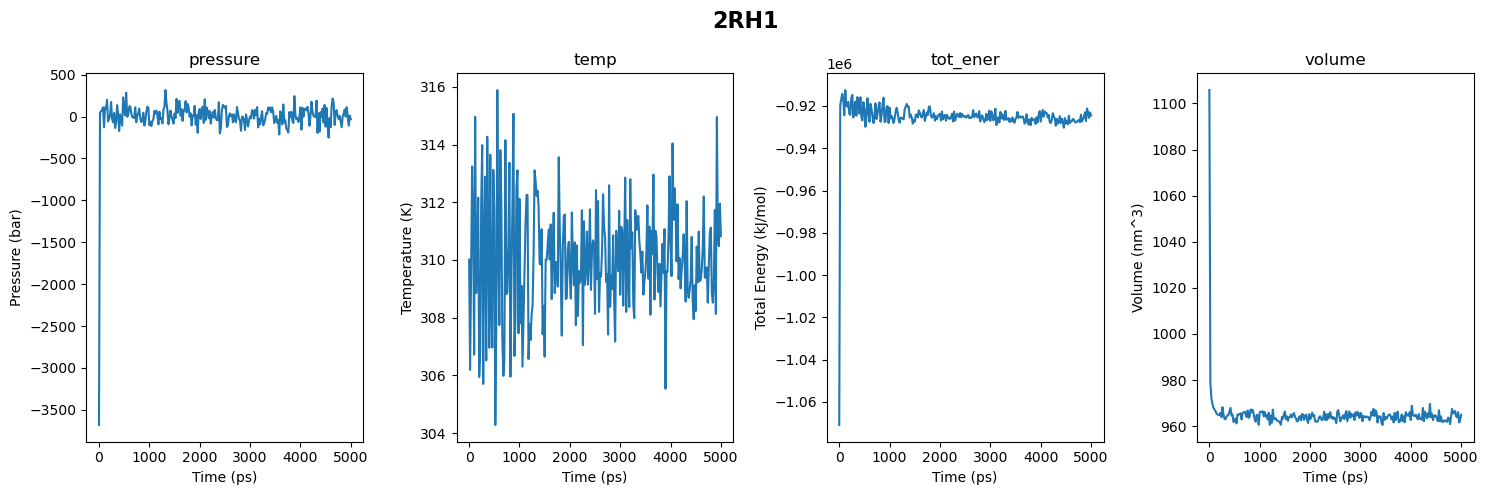

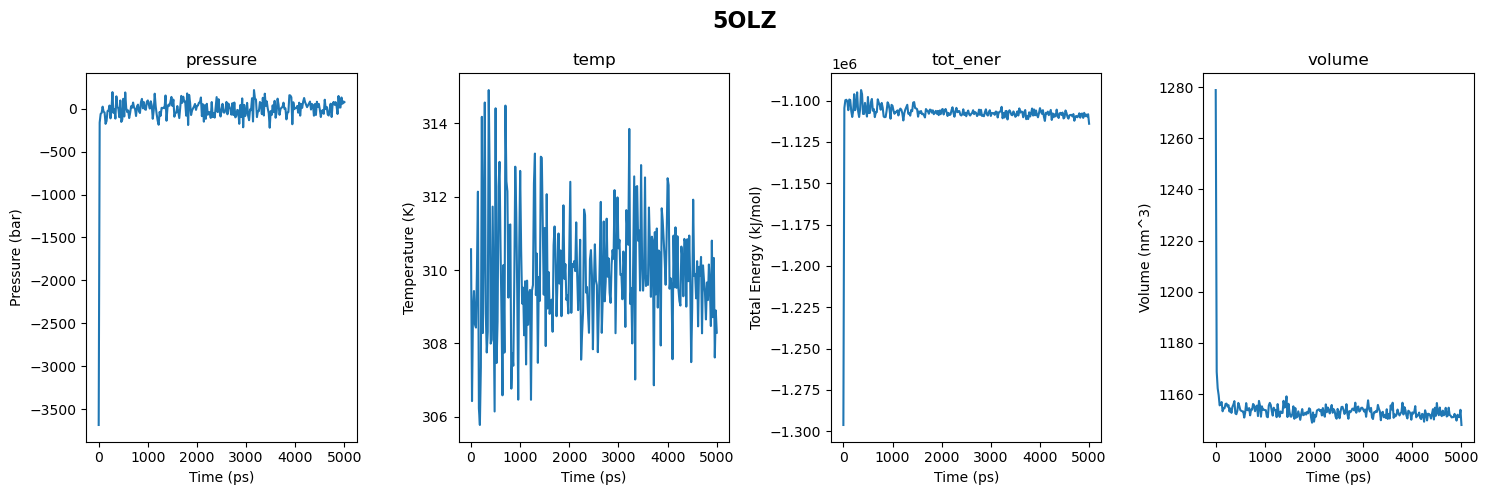

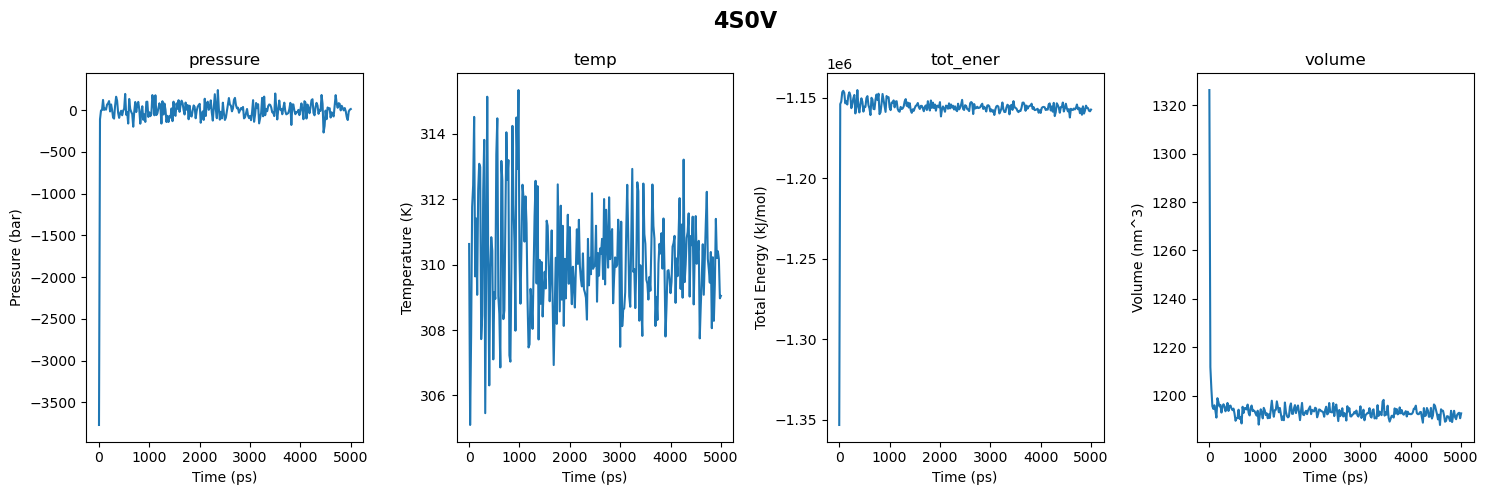

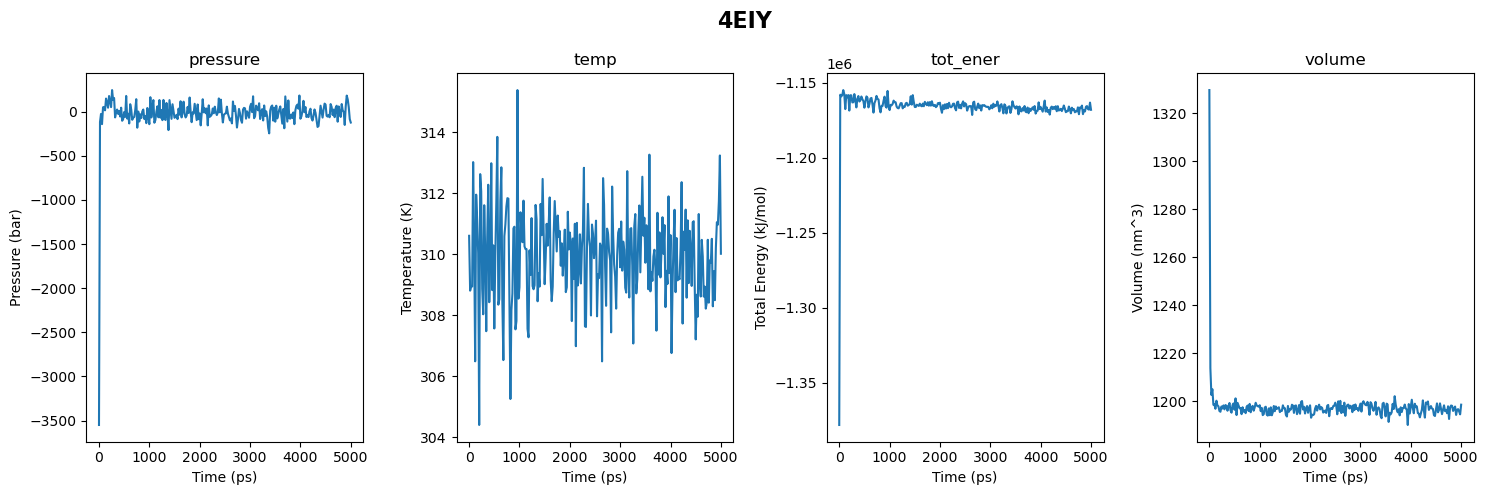

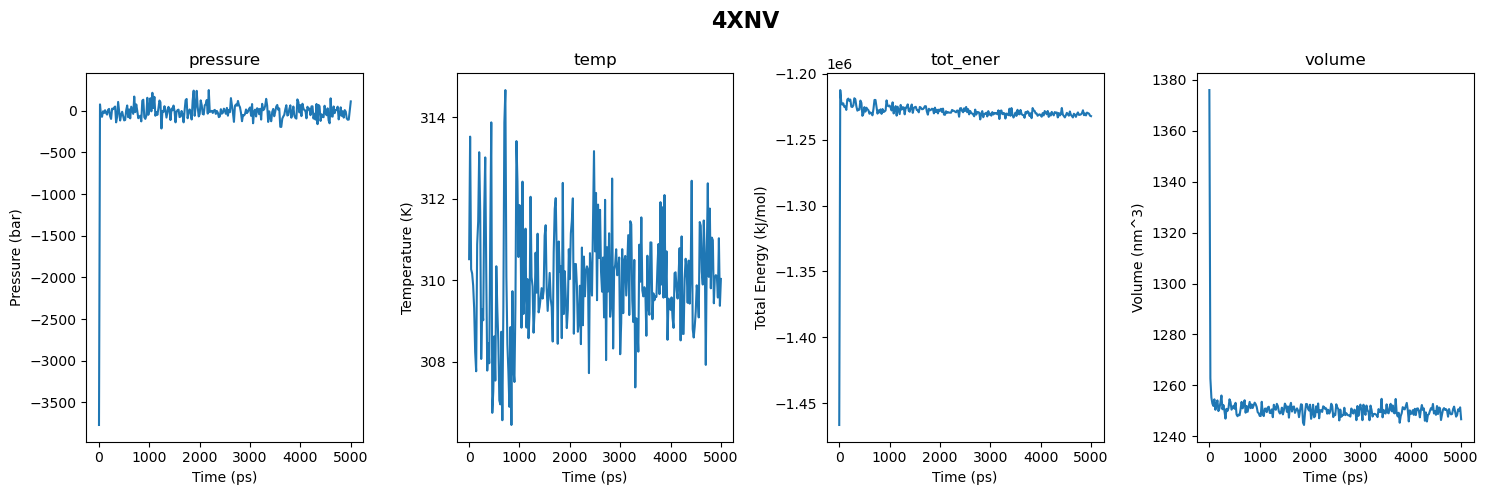

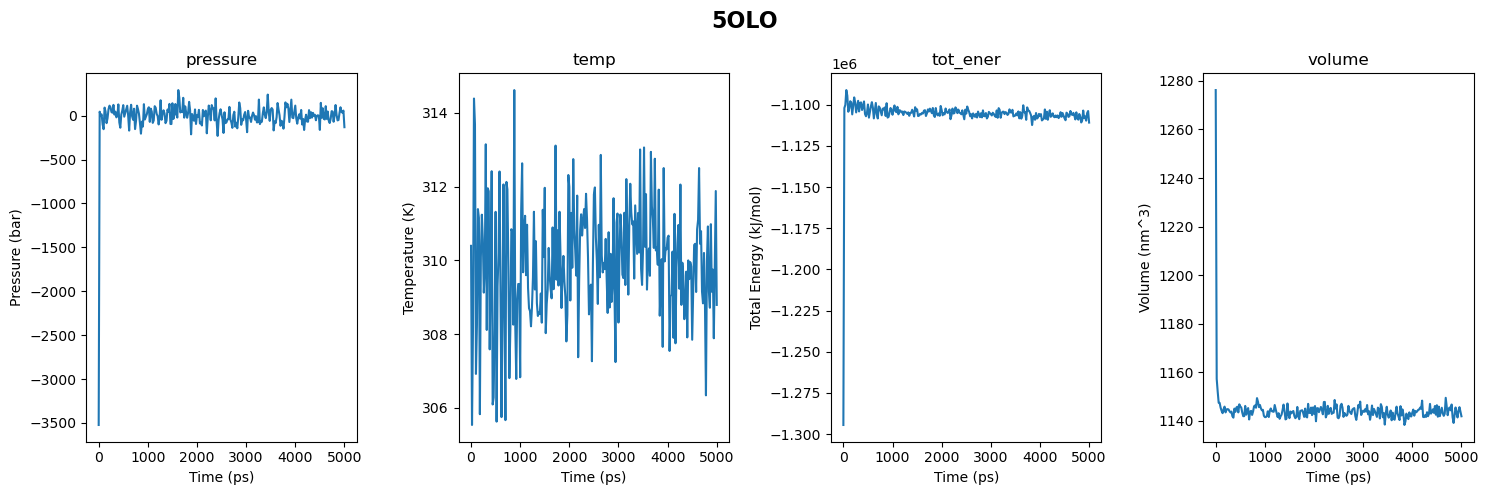

In [4]:
for report in PMD_Reports:
    report.plot('system')

## Protein structure equilibration during membrane insertion

In the following figure, the root mean square difference of atomic position for each protein structure with respect to its initial configuration are plotted. There are several plots depicting either the RMSD changes of all atoms (`rmsd-all-atoms-vs-start`), only backbone atoms (`rmsd-backbone-vs-start`; the nitrogen-alpha carbon-carbon chains), or only the alpha carbons (`rmsd-calpha-vs-start`) over time. The plot `rmsf-per-residue` shows the root mean quare fluctuation (RMSF), the average deviation with respect to initial position for each amino acid residue.

Overall, it can be observed that all 6 protein-membrane systems get equillibrated. During the different relaxation steps where either all protein heavy atoms are restrained under decreasing force constants (1000-200 kJ/mol/nm^3 for equilibration steps 1-6; red dashed lines in figure) or only the Venkatakrishnan pairs / BW residues are restrained, the whole protein systems converge to an equilibrium with a RMSD of approx. 1-2 Ängstrom with respect to original configuration. 

The RMSD's of the backbone / C-alpha atoms is slightly lower than the all-atom RMSD. This can be explained by the equilibration steps (in which only heavy atoms are restrained), and their atomic masses being larger than that of the many hydrogens, which cause them to experience slower movement.

Some residues are observed to have considerably larger root mean square fluctuations (RMSFs) than other residues

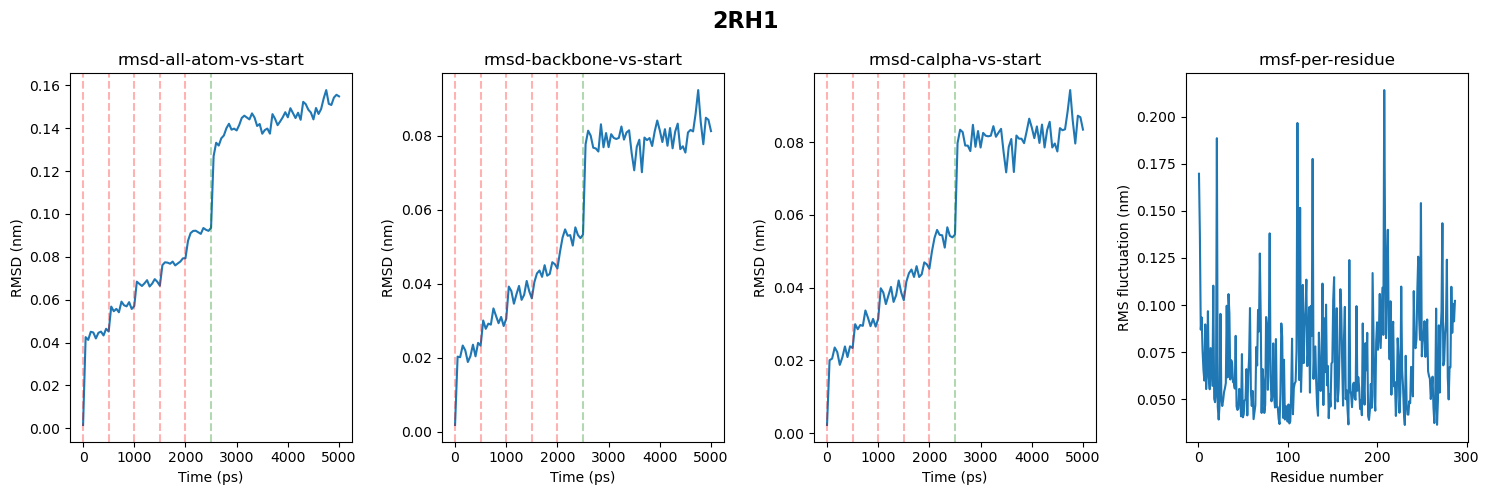

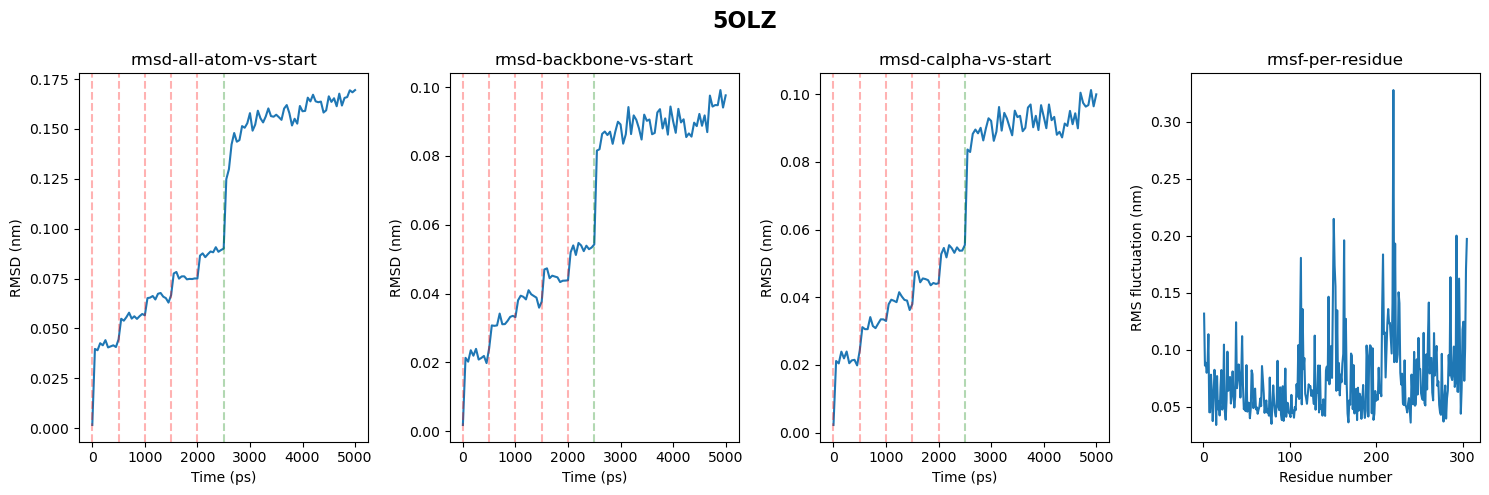

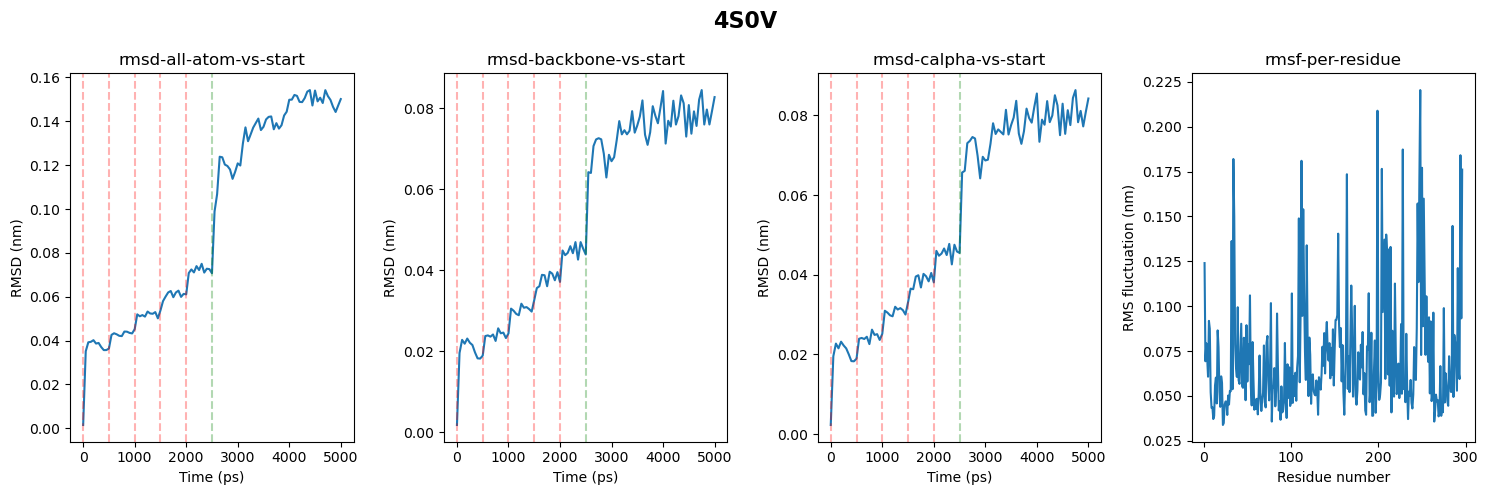

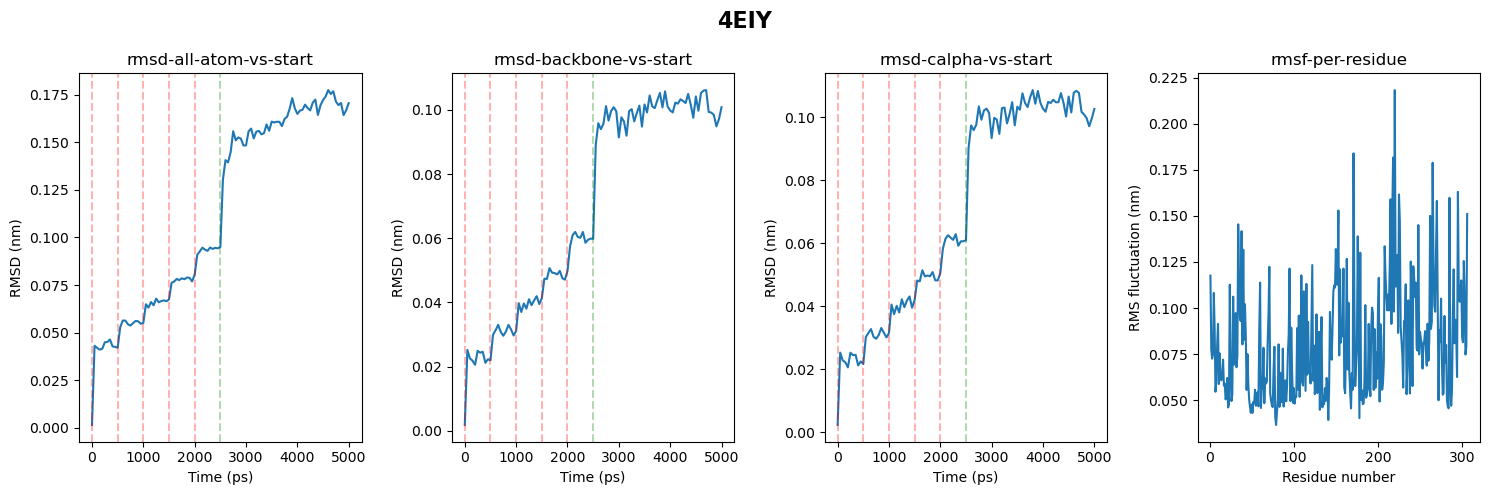

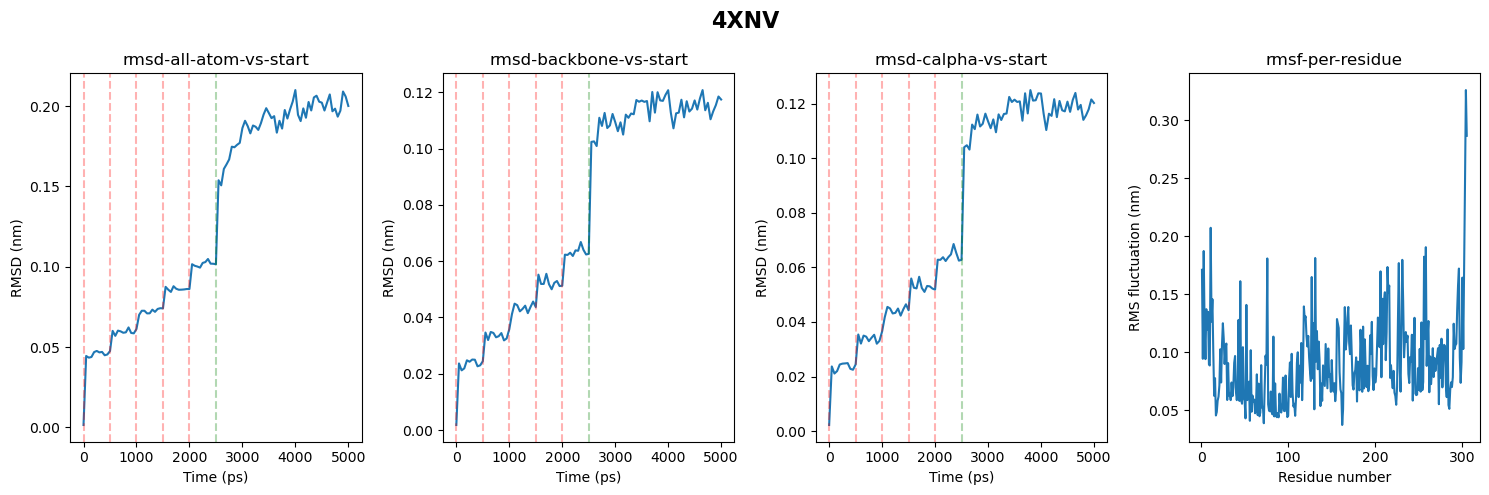

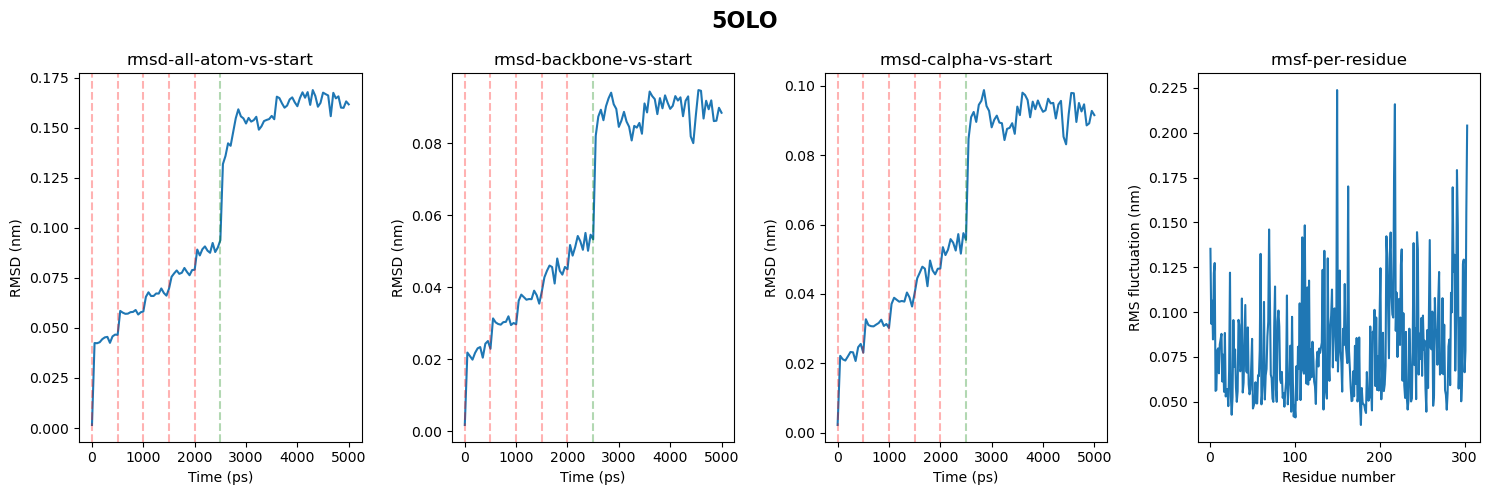

In [5]:
for report in PMD_Reports:
    report.plot('residualmeans')

### Possible explanations for RMSF outliers

1. The most flexible residues displaying the highest RMSF are located in extra- and intracellular loops.
2. The highest RMSF residues are small.

#### Residue number - amino acid code assignment
The `.pdb` structures used for PyMemDyn often / all had truncated N-termini, which makes an automatic assignment of the correct amino acid code to each residue number difficult. I manually checked each `.pdb` structure that was used as PyMemDyn input file to and cross-referenced its residue sequence with the sequence on [gpcrdb](https://gpcrdb.org/) to re-index each amino acid residue correctly. This information is stored in the `offsets_and_fills`-dictionary.



In [6]:
offsets_and_fills = {
    '2RH1': [(1, 202, +28), (203, 207, 'A'), (208, 287, +55)],
    '4EIY': [(1, 210, -2), (211, 216, 'A'), (217, 265, +2), (266, 267, 'A'), (268, 306, +1)],
    '4S0V': [(1, 205, +49), (206, 208, 'A'), (209, 296, +85)],
    '4XNV': [(1, 118, +38), (119, 126, 'A'), (127, 216, +31), (217, 223, 'A'), (224, 305, +29)],
    '5OLO': [(1, 210, -2), (211, 216, 'A'), (217, 303, +2)],
    '5OLZ': [(1, 210, -2), (211, 218, 'A'), (219, 305, 0)]
}

def in_file_to_real_residue(resnumber_array, offsets_and_fills_list):
    """
    Converts in-file residue number sequence from PyMemDyn log to correct residue sequence based on manual labels
    """
    converted_resnumber_array = resnumber_array.copy()
    

    for interval in offsets_and_fills_list:
        if interval[2] != 'A':
            converted_resnumber_array[interval[0]-1:interval[1]] += interval[2]
        
        elif interval[2] == 'A':
            converted_resnumber_array[interval[0]-1:interval[1]] = None

        else:
            return RuntimeError('Incorrect interval tuple formatting')
            
    return converted_resnumber_array
    

In [7]:
import gpcrmining.gpcrdb as db

res_info_A2A = db.get_residue_info('aa2ar_human')
res_info_Beta2Adr = db.get_residue_info('adrb2_human')
res_info_P2Y1 = db.get_residue_info('p2ry1_human')
res_info_OX2 = db.get_residue_info('ox2r_human')

A2A_template = pd.DataFrame(res_info_A2A, columns=['Domain', 'ResidueNumber', 'ResidueCode', 'BW'])
Beta2Adr_template = pd.DataFrame(res_info_Beta2Adr, columns=['Domain', 'ResidueNumber', 'ResidueCode', 'BW'])
P2Y1_template = pd.DataFrame(res_info_P2Y1, columns=['Domain', 'ResidueNumber', 'ResidueCode', 'BW'])
OX2_template = pd.DataFrame(res_info_OX2, columns=['Domain', 'ResidueNumber', 'ResidueCode', 'BW'])

Using the `gpcrmining.gpcrdb`-package as gpcr db API, and the manually created dictionary, the residue numbers of each report's RMSF data can be corrected. The correctly indexed residue sequences (as well as BW numbering, residue code, and protein Domain) are stored in the `sequence_info_dfs`-dictionary.

In [8]:
sequence_info_dfs = {}

for report in PMD_Reports:
    # load rmsf data
    in_file_resnumbers, in_file_rmsf = report.load_data('rmsf-per-residue.xvg')  
    
    # generate correct residue sequence 
    offsets_fills_list = offsets_and_fills[report.pdbcode]
    real_resnumbers = in_file_to_real_residue(in_file_resnumbers, offsets_fills_list) 

    
    df = pd.DataFrame({
        'InfileRsidueNumber': in_file_resnumbers,
        'ResidueNumber': real_resnumbers,
        'RMSF': in_file_rmsf
        })

    # set matching template to correct GPCR_db entry based protein
    if report.pdbcode in ['4EIY', '5OLZ', '5OLO']:
        gpcr_db_template = A2A_template
    elif report.pdbcode == '2RH1':
        gpcr_db_template = Beta2Adr_template
    elif report.pdbcode == '4S0V':
        gpcr_db_template = OX2_template
    elif report.pdbcode == '4XNV':
        gpcr_db_template = P2Y1_template

    # merge df with template on real residue numbers
    df = pd.merge(df, gpcr_db_template, how='left', on=['ResidueNumber'])
    
    # label poly-A regions
    df['Domain'] = df['Domain'].fillna('Modelled/Poly-Ala')
    df['ResidueCode'] = df['ResidueCode'].fillna('A')

    # save df into sequence_info_dfs
    df_name = f'data_{report.pdbcode}'
    sequence_info_dfs[df_name] = df

What follows here is a function which goes through each report's dataframe (e.g. `sequence_info_dfs['data_2R1H']`), and generates a dictionary which contains the first and last residue for each gpcr-db annotated protein domain found in the data. This information will be used to create the new residue - RMSF plots.

In [9]:
def domain_labeller(seq_info_df):
     
    DomainsToLabel = {} # 'TM1': (1,2)

    DomainName = seq_info_df.iloc[0].get('Domain')
    DomainStart = seq_info_df.iloc[0].get('ResidueNumber')
    DomainEnd = int(0)

    for index, row in seq_info_df.iterrows():
        if row[3] != DomainName:
                if row[3] == 'Modelled/Poly-Ala':

                    DomainEnd = seq_info_df.iloc[index-1].get('ResidueNumber')

                    DomainsToLabel[DomainName] = (DomainStart, DomainEnd)
                    DomainName = row[3]

                    
                else:
                    DomainEnd = row[1]
                    DomainEnd = row[1]-1
                    DomainsToLabel[DomainName] = (DomainStart, DomainEnd)

                    DomainName = row[3]
                    DomainStart = (row[1])

                    if index == seq_info_df.shape[0]-1:
                        
                        DomainName = row[3]
                        DomainEnd = row[1]
                        DomainsToLabel[DomainName] = (DomainStart, DomainEnd)
    
    return DomainsToLabel

/var/folders/5z/10m2qplj4qj3rl5cq75k57600000gp/T/ipykernel_48586/557351595.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[3] != DomainName:
/var/folders/5z/10m2qplj4qj3rl5cq75k57600000gp/T/ipykernel_48586/557351595.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[3] == 'Modelled/Poly-Ala':
/var/folders/5z/10m2qplj4qj3rl5cq75k57600000gp/T/ipykernel_48586/557351595.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

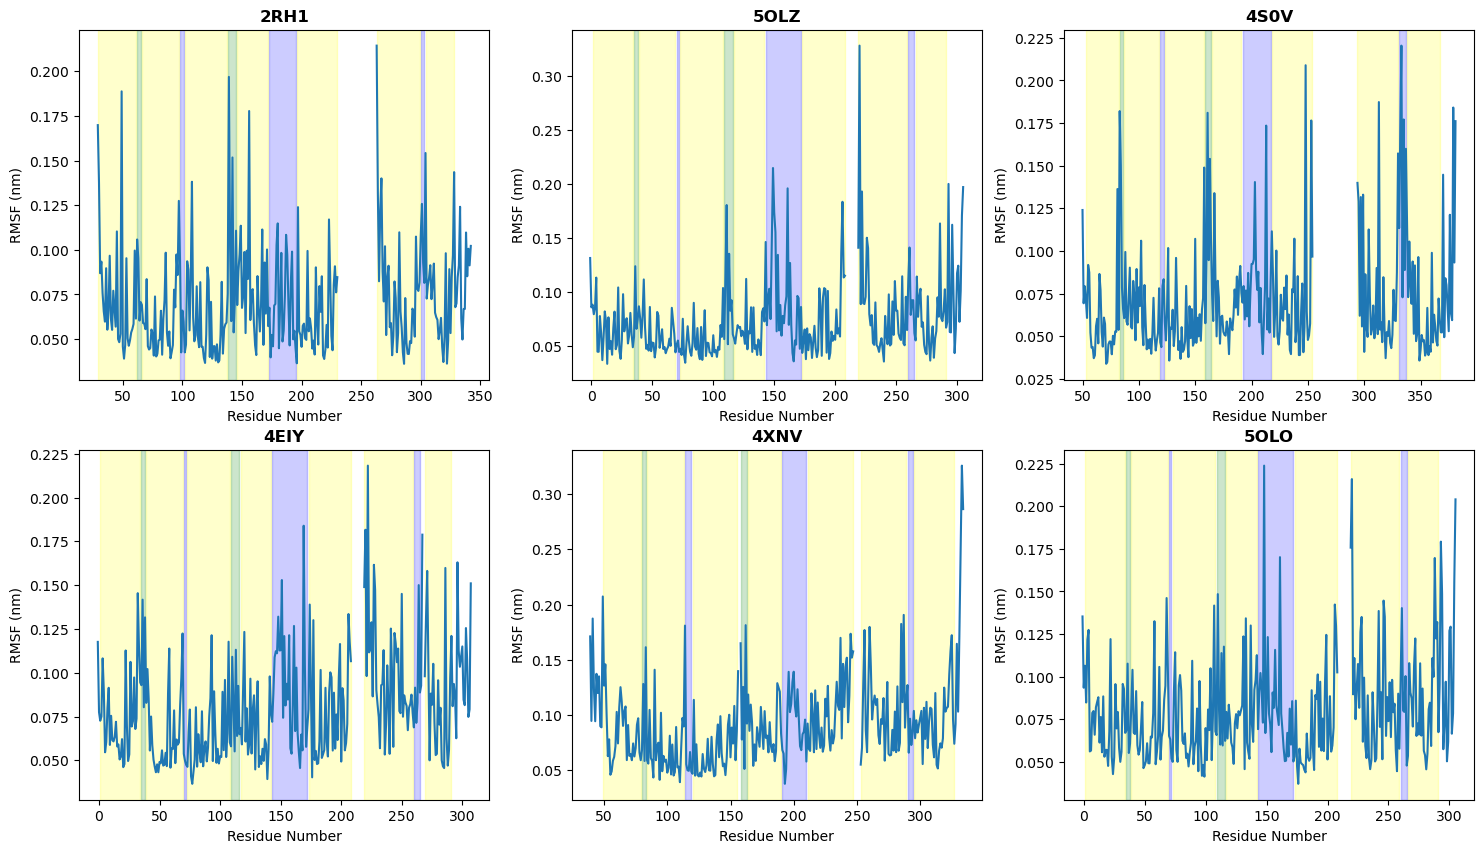

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,10) )
axes = axes.flatten()

for i, name in enumerate(sequence_info_dfs):
    ax = axes[i]
    x = sequence_info_dfs[name]['ResidueNumber']
    y = sequence_info_dfs[name]['RMSF']
    ax.plot(x,y)

    ax.set_title(name[-4:], fontweight='bold')
    ax.set_xlabel('Residue Number')
    ax.set_ylabel('RMSF (nm)')

    labels = domain_labeller(sequence_info_dfs[name])
        
    for domain, interval in labels.items():
        if 'TM' in domain:
            color = 'yellow'
            ax.axvspan(interval[0], interval[1], alpha=0.2, color=color, label=domain)
        elif 'ICL' in domain:
            color = 'green'
            ax.axvspan(interval[0], interval[1], alpha=0.2, color=color, label=domain)
        elif 'ECL' in domain:
            color = 'blue'
            ax.axvspan(interval[0], interval[1], alpha=0.2, color=color, label=domain)

## Interpretation of RMSF outliers for the 6 systems during protein-membrane embedding

It can be observed in the figure that most RMSF outliers are observed in either 
1. the intracellular (blue area) and extracellular (green) regions, or
2. around/in the modelled poly-alanine regions or C-, N-termini (white areas)

This is to be expected, as the residues in the loopregion and termini domains are more flexible, especially if these regions are large. The RMSF outliers that are located right next to the modelled poly-A chain sequences also do not constitute a large problem, since 1) these modelled regions were not equilibrated separately before membrane embedding (which could cause a large initial movement of adjacent proteins when the forcefields are turned on), and 2) they are located far from the binding site, anyway. Furthermore, the absolute RMSF values are modest, even for these outliers (1.5-2 Ä).

### Two 'unexplained' outliers

There seem to be two exceptions, RMSF outlier residues which are located in the transmembranal regions, namely:
1. **4S0V**: R248 (BW 5.63x63), which is located in TM5 of the orexin 2 receptor (RMSF = 2.089 Ä), and
2. **2R1H**: F49 (BW 1.48x48), which is located in TM1 of the Beta 2 adrenergic receptor (RMSF = 1.887 Ä).

#### Phe-49, in structure 2R1H (beta 2 adrenergic receptor)
After manual inspection of the snapshots generated throughout the membrane insertion trajectory with PyMol (see `traj_pymol.xtc`, `load_gpcr.pml` in MD outputs), it was observed that phenylalanine-49 'flips' around its beta-carbon (see image below, F49 is colored green, POPC lipids are colored cyan, protein backbone is dark blue / red). In this position, its phenyl carbons interact with the hydrophobic tails of the POPC molecules (distance between ca. 2.5 - 3.25 Ä). After this 'flip' has occured, the residue does not move back to its initial orientation. Since the phenyl group is oriented towards the solvent / membrane side, it does not have a large effect of the position of the protein backbone. Furthermore, residue 49 is located far away from the orthosteric binding site. It does not pose a problem for the FEP / MD simulations.

![F49 flippping throughout trajectory](pictures/2RH1_F49_before_after.png)

#### Arg-248, in structure 4S0V (orexin 2 receptor)
Residue arginine 248 is located at the end of transmembranal domain 5, and in the protein-membrane model finds itself at the border of the model, which is simulated under spherical boundary conditions (see image below, R248 is colored green, POPC lipids are colored grey, protein backbone is colored yellow), where it has access to the polar head groups of the POPC molecules, but the long carbon-guanidium residue chain cannot easily rotate freely. During the MD simulations it eventually flips around. It is difficult to ascertain whether the residue does not move back to its original position because it is 'really' thermodynamically more favourable due to a change in interaction profile, or whether this is the case because it gets blocked by the SBC boundary (and is therefore a sort of 'not-physical artifact'). Still, this residue is, like Phe-49 in the previous protein, also located far away from the orthosteric binding site, and it is also unlikely to hinder MD simulations during FEP.

![R248 at SBC border](pictures/4S0V_R248_before_after.png)











#### Comments on progress update presentation (9 jan 2025):
*RMSF residue outliers: (from Gerard, Remco)*
- BW numbering (https://docs.gpcrdb.org/generic_numbering.html)
- Still, manually inspect snapshots of high rmsf aa's: is there something interesting happening?
- Remco offered to help with it 

*Resolution (from Gerard)*
- not as important with dynamic MD simulations since any wrong "shifts" will sort themselves out using forcefields. As long as the general protein is modelled correctly.
- It does become more important when you want to dock on a static structure